cat project_data.zip | ssh -T vshishkov-243998@gateway.st "kubectl exec --stdin pod/jupyter-spark-7d48566c67-58jql -- hdfs dfs -put -f - /tmp/vshishkov-243998/project_data.zip"

HDFS -> Local -> Extracting -> HDFS

In [1]:
# !if [ ! -f "/home/jovyan/work/project_data.zip" ]; then hdfs dfs -copyToLocal /tmp/vshishkov-243998/project_data.zip ~/work/project_data.zip; fi; 
# !if [ ! -d "/home/jovyan/work/project_data" ]; then unzip -qq ~/work/project_data.zip -d ~/work; fi;
# !hdfs dfs -rm -r /tmp/vshishkov-243998/project_data
# !hdfs dfs -put -f ~/work/project_data /tmp/vshishkov-243998/project_data

pip install \
    --user \
    --trusted-host pypi-service.pypi \
    --index-url http://pypi-service.pypi:8080/ \
    sklearn

Imports

In [2]:
import os
import socket
import datetime
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf, length, when, col
import pyspark.sql.types as ps_types
import pyspark.sql.functions as F

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor

Base dirs

In [3]:
data_dir = Path("/home/jovyan/work/project_data")
currencies_dir = data_dir / "currencies"
gtrends_dir = data_dir / "google trends"
reddit_dir = data_dir / "reddit"
twitter_dir = data_dir / "twitter/combined_all_coins_tweet_data"

hdfs_data_dir = Path("hdfs://tmp/vshishkov-243998/project_data")
hdfs_currencies_dir = hdfs_data_dir / "currencies"
hdfs_gtrends_dir = hdfs_data_dir / "google trends"
hdfs_reddit_dir = hdfs_data_dir / "reddit"
hdfs_twitter_dir = hdfs_data_dir / "twitter/combined_all_coins_tweet_data"
hdfs_models_dir = hdfs_data_dir / "models"
hdfs_preds_dir = hdfs_data_dir / "preds"
hdfs_scalers_dir = hdfs_data_dir / "scalers"

Spark session

In [4]:
LOCAL_IP = socket.gethostbyname(socket.gethostname())
spark = (SparkSession
    .builder
    .master('k8s://https://10.32.7.103:6443')
    .config('spark.driver.host', LOCAL_IP)
    .config('spark.driver.bindAddress', '0.0.0.0')
    .config('spark.executor.instances', '2')
    .config('spark.executor.cores', '2')
    .config('spark.cores.max', '4')
    .config('spark.executor.memory', '4g')
    .config('spark.sql.execution.arrow.enabled', 'true')
    .config('spark.kubernetes.namespace', 'vshishkov-243998')
    .config('spark.kubernetes.container.image', 'node03.st:5000/spark-executor:vshishkov-243998')
    .config('spark.kubernetes.container.image.pullPolicy', 'Always')
    .config('spark.kubernetes.executor.deleteOnTermination', 'false')
    .getOrCreate()
)

Reading metadata

In [5]:
# all metadata in format { lowered ticker : hdfs path to file }

# currencies data
coins_meta = pd.read_csv(currencies_dir / "coins.csv")
coins_meta = {x.lower(): (hdfs_currencies_dir / f"{x.upper()}.csv").as_posix() for x in coins_meta.Coin}

# google trends data
gtrends_data = spark.read.option("multiline", True).option('escape', "\"").csv((hdfs_gtrends_dir / "GT_adj.csv").as_posix(), header=True, inferSchema=True)\
    .withColumnRenamed("_c0", "gtrends_date")\
    .withColumn("gtrends_date", F.to_timestamp(col("gtrends_date"), "yyyy-MM-dd"))
gtrends_meta = [x.split("_")[0].lower() + "-usd" for x in gtrends_data.columns[1:]]

# reddit data
reddit_meta = pd.read_csv(reddit_dir / "meta_info.csv")
reddit_meta = {row.ticker.lower(): (hdfs_reddit_dir / f"{row.subreddit}_features.csv").as_posix() for _, row in reddit_meta.iterrows()}

# twitter data
twitter_meta = {x.stem.lstrip("tweets_") + "-usd": Path(*hdfs_data_dir.parts, *[x for x in (twitter_dir / x.stem).glob("*") if "feat" in x.stem][0].parts[- 4:]).as_posix() for x in twitter_dir.iterdir()}

# intersection
coins_all = set(coins_meta.keys()) & set(reddit_meta.keys()) & set(twitter_meta.keys() & set(gtrends_meta))
len(coins_all)

18

In [6]:
def create_lags(df, date_col, lags_num, cols_to_lag):
    w = Window().partitionBy().orderBy(col(date_col))
    return df.select([date_col] + [F.lag(col_to_lag, lag).over(w).alias(f"{col_to_lag}_{lag}")\
                     for lag in range(1, lags_num + 1) for col_to_lag in cols_to_lag]).na.drop()

get_item0_udf = F.udf(lambda x : float(x[0]), ps_types.DoubleType())

def create_train_test(df, date_col, target_col, lags_num, test_size, scale=False):
    # creating lags
    df = df.join(create_lags(df, date_col=date_col, lags_num=lags_num, 
                             cols_to_lag=[x for x in coin_data.columns if x != date_col]),
               on=date_col, how="inner").sort("Date")
    
    # splitting
    train_len = round((1 - test_size) * df.count())
    train_df = df.limit(train_len)
    test_df = df.subtract(train_df)
    
    # assembling
    va_features = VectorAssembler(inputCols=[x for x in df.columns if x != date_col and x != target_col], outputCol="features")
    va_target = VectorAssembler(inputCols=[target_col], outputCol="target")
    va_transform = lambda x: va_target.transform(va_features.transform(x)).select("features", "target", "Date")
    train, test = map(va_transform, (train_df, test_df))
    
    # scaling
    if scale:
        features_scaler = StandardScaler(inputCol="features", outputCol="scaled_features",
                            withStd=True, withMean=True).fit(train)
        target_scaler = StandardScaler(inputCol="target", outputCol="scaled_target",
                            withStd=True, withMean=True).fit(train)
        scale = lambda x: target_scaler.transform(features_scaler.transform(x))\
            .select(col("scaled_features").alias("features"), get_item0_udf(col("scaled_target")).alias("target"), "Date")
#         mean = train_df.agg(F.mean(col(target_col)).alias("mean")).collect()[0]['mean']
#         std = train_df.agg(F.stddev(col(target_col)).alias("std")).collect()[0]['std']
#         scale = lambda x: features_scaler.transform(x)\
#             .select(col("scaled_features").alias("features"), ((get_item0_udf(col("target")) - mean) / std).alias("target"))
    else:
        features_scaler = target_scaler = None
        features_scaler = StandardScaler(inputCol="features", outputCol="scaled_features",
                            withStd=True, withMean=True).fit(train)
        scale = lambda x: features_scaler.transform(x).select(col("scaled_features").alias("features"),
                    get_item0_udf(col("target")).alias("target"), "Date")
    train, test = map(scale, (train, test))
    
    return train, test, features_scaler, target_scaler

def get_mae(preds):
    return preds.select(F.sum(F.abs(col("prediction") - col("target"))).alias("MAE")).collect()[0].MAE

def eval_model(model, train, test, metric_func):
    model = model.fit(train)
    preds = model.transform(test)
    metric = metric_func(preds)
    return model, metric, preds

Training / evaluation routine

In [7]:
test_part = 0.2
models = [LinearRegression, RandomForestRegressor]
models_params = [{"featuresCol": "features", "labelCol": "target"},
                {"featuresCol": "features", "labelCol": "target", "numTrees": 10, "maxDepth": 5, "seed": 42}]
results = {"model": [], "coin": [], "metric": []}

for coin in tqdm(coins_all):
    flag = False
    while not flag:
        try:
            #  reading all the data
            coin_data = spark.read.option("mode", "DROPMALFORMED").csv(coins_meta[coin], header=True, inferSchema=True).drop("Dividends", "Stock Splits")
            coin_data = coin_data.withColumn("Date", F.to_timestamp(coin_data.Date, "yyyy-MM-dd"))

            coin_gtrends_data = gtrends_data.select("gtrends_date", f"{coin[: - 4].upper()}_adj_svi")

            reddit_data = spark.read.option("mode", "DROPMALFORMED").option("multiline", True).option('escape', "\"").csv(reddit_meta[coin], header=True, inferSchema=True)
            reddit_data = reddit_data.withColumn("date", F.to_timestamp(reddit_data.date, "yyyy-MM-dd"))\
                            .withColumnRenamed("date", "reddit_date")

            twitter_data = spark.read.option("mode", "DROPMALFORMED").csv(twitter_meta[coin], header=True, inferSchema=True).drop("_c0", "Unnamed: 0")
            twitter_data = twitter_data.withColumn("date", F.to_timestamp(twitter_data.date, "yyyy-MM-dd"))\
                            .withColumnRenamed("date", "twitter_date")

            #  merging data
            tr_data = twitter_data.join(reddit_data, twitter_data.twitter_date == reddit_data.reddit_date, "inner")
            ctr_data = coin_data.join(tr_data, coin_data.Date == tr_data.reddit_date, "left")
            full_data = ctr_data.join(coin_gtrends_data, ctr_data.Date == coin_gtrends_data.gtrends_date, "left")
            full_data = full_data.drop("reddit_date", "twitter_date", "gtrends_date").fillna(0)

            #  transformation to train / test
            train, test, features_scaler, target_scaler = create_train_test(full_data, "Date", "Close", 1, 0.2, scale=True)
            target_scaler.write().overwrite().save((hdfs_scalers_dir / coin).as_posix())
            train.cache()
            test.cache()

            #  evaluation of the models
            for model, model_params in zip(models, models_params):
                model, metric, preds = eval_model(model(**model_params), train, test, get_mae)

                model_type = model.uid.split('_')[0]
                results["model"].append(model_type)
                results["coin"].append(coin)
                results["metric"].append(metric)
                model.write().overwrite().save((hdfs_models_dir / f"{model_type}_{coin}").as_posix())
                preds.select("target", "prediction").write.mode('overwrite').parquet((hdfs_preds_dir / f"{model_type}_{coin}.parquet").as_posix())

            train.unpersist()
            test.unpersist()
            flag = True
        except Exception as e:
            print(e)
    
results = pd.DataFrame(results)
results

 28%|██▊       | 5/18 [25:38<1:01:46, 285.11s/it]

An error occurred while calling o4283.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 80 in stage 1027.0 failed 4 times, most recent failure: Lost task 80.3 in stage 1027.0 (TID 20731) (10.128.128.52 executor 8): org.apache.spark.SparkException: EOFException occurred while reading the port number from pyspark.daemon's stdout
	at org.apache.spark.api.python.PythonWorkerFactory.startDaemon(PythonWorkerFactory.scala:217)
	at org.apache.spark.api.python.PythonWorkerFactory.createThroughDaemon(PythonWorkerFactory.scala:132)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:105)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:70)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExe

 83%|████████▎ | 15/18 [1:11:01<11:16, 225.37s/it]

An error occurred while calling o12139.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 50 in stage 2994.0 failed 4 times, most recent failure: Lost task 50.3 in stage 2994.0 (TID 56249) (10.128.128.61 executor 21): java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:397)
	at org.apache.spark.api.python.PythonWorkerFactory.createSocket$1(PythonWorkerFactory.scala:120)
	at org.apache.spark.api.python.PythonWorkerFactory.liftedTree1$1(PythonWorkerFactory.scala:136)
	at org.apache.spark.api.python.PythonWorkerFactory.createThroughDaemon(PythonWorkerFactory.scala:135)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:105)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:70)
	at org.ap

 89%|████████▉ | 16/18 [1:17:34<09:11, 275.85s/it]

An error occurred while calling o13362.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 3269.0 failed 4 times, most recent failure: Lost task 2.3 in stage 3269.0 (TID 62017) (10.128.117.215 executor 22): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:550)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:539)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:89)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:67)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator

100%|██████████| 18/18 [1:28:55<00:00, 296.42s/it]


,model,coin,metric
0,LinearRegression,bnb-usd,58.141663
1,RandomForestRegressor,bnb-usd,115.422201
2,LinearRegression,xmr-usd,15.386517
3,RandomForestRegressor,xmr-usd,30.116431
4,LinearRegression,btc-usd,70.721581
5,RandomForestRegressor,btc-usd,3669.071687
6,LinearRegression,xrp-usd,13.524856
7,RandomForestRegressor,xrp-usd,37.402920
8,LinearRegression,dot-usd,6.954707
9,RandomForestRegressor,dot-usd,11.225788


In [8]:
preds.show()

+--------------------+-------------------+-------------------+-------------------+
|            features|             target|               Date|         prediction|
+--------------------+-------------------+-------------------+-------------------+
|[0.43962523970086...|0.33852174470613594|2022-02-11 00:00:00| 0.4079761059700112|
|[0.33861415602650...| 0.3482065857091885|2022-02-12 00:00:00|0.35531184910968017|
|[0.35011420615242...|  0.334398617204938|2022-02-13 00:00:00| 0.3416082644659399|
|[0.33487845291639...|0.30178901403802894|2022-02-14 00:00:00| 0.3416082644659399|
|[0.30388360189197...| 0.4342712315936625|2022-02-15 00:00:00| 0.3416082644659399|
|[0.43619183827641...| 0.4402479748334851|2022-02-16 00:00:00| 0.3416082644659399|
|[0.44151031844018...|0.28904807360203805|2022-02-17 00:00:00| 0.3753284671858196|
|[0.29187727707208...| 0.2773517165520826|2022-02-18 00:00:00| 0.3416082644659399|
|[0.27913065530612...| 0.2606887844689299|2022-02-19 00:00:00| 0.3416082644659399|
|[0.

In [9]:
results.groupby("model").mean()

,metric
model,
LinearRegression,27.620866
RandomForestRegressor,273.486508


In [10]:
spark.createDataFrame(results).write.mode('overwrite').csv((hdfs_data_dir / "results.csv").as_posix())

Without media

In [11]:
results_pure = {"model": [], "coin": [], "metric": []}

for coin in tqdm(coins_all):
    flag = False
    while not flag:
        try:
            #  reading all the data
            coin_data = spark.read.option("mode", "DROPMALFORMED").csv(coins_meta[coin], header=True, inferSchema=True).drop("Dividends", "Stock Splits")
            coin_data = coin_data.withColumn("Date", F.to_timestamp(coin_data.Date, "yyyy-MM-dd"))

            #  transformation to train / test
            train, test, features_scaler, target_scaler = create_train_test(coin_data, "Date", "Close", 1, 0.2, scale=True)
#             target_scaler.write().overwrite().save((hdfs_scalers_dir / coin).as_posix())
            train.cache()
            test.cache()

            #  evaluation of the models
            for model, model_params in zip(models, models_params):
                model, metric, preds = eval_model(model(**model_params), train, test, get_mae)

                model_type = model.uid.split('_')[0]
                results_pure["model"].append(model_type)
                results_pure["coin"].append(coin)
                results_pure["metric"].append(metric)
#                 model.write().overwrite().save((hdfs_models_dir / f"{model_type}_{coin}").as_posix())
#                 preds.select("target", "prediction").write.mode('overwrite').parquet((hdfs_preds_dir / f"{model_type}_{coin}.parquet").as_posix())

            train.unpersist()
            test.unpersist()
            flag = True
        except Exception as e:
            print(e)
    
results_pure = pd.DataFrame(results_pure)
results_pure

  6%|▌         | 1/18 [00:13<03:51, 13.63s/it]

An error occurred while calling o15804.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 3770.0 failed 4 times, most recent failure: Lost task 4.3 in stage 3770.0 (TID 70175) (10.128.117.219 executor 26): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:550)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:539)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:89)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:67)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator

 22%|██▏       | 4/18 [03:33<10:29, 45.00s/it] 

An error occurred while calling o17859.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 3957.0 failed 4 times, most recent failure: Lost task 0.3 in stage 3957.0 (TID 71538) (10.128.128.59 executor 25): org.apache.spark.SparkException: EOFException occurred while reading the port number from pyspark.daemon's stdout
	at org.apache.spark.api.python.PythonWorkerFactory.startDaemon(PythonWorkerFactory.scala:217)
	at org.apache.spark.api.python.PythonWorkerFactory.createThroughDaemon(PythonWorkerFactory.scala:132)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:105)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:70)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExe

 44%|████▍     | 8/18 [06:36<05:27, 32.74s/it]

An error occurred while calling o20462.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 185 in stage 4197.0 failed 4 times, most recent failure: Lost task 185.3 in stage 4197.0 (TID 73041) (10.128.117.209 executor 27): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:550)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:539)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:89)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:67)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIter

 89%|████████▉ | 16/18 [12:06<00:43, 21.91s/it]

An error occurred while calling o25670.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 19 in stage 4677.0 failed 4 times, most recent failure: Lost task 19.3 in stage 4677.0 (TID 76554) (10.128.117.218 executor 29): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:550)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:539)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:89)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:67)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterat

100%|██████████| 18/18 [12:49<00:00, 42.74s/it]


,model,coin,metric
0,LinearRegression,bnb-usd,17.002522
1,RandomForestRegressor,bnb-usd,140.459650
2,LinearRegression,xmr-usd,13.235198
3,RandomForestRegressor,xmr-usd,27.408966
4,LinearRegression,btc-usd,69.574715
5,RandomForestRegressor,btc-usd,3606.136179
6,LinearRegression,xrp-usd,12.317904
7,RandomForestRegressor,xrp-usd,32.442800
8,LinearRegression,dot-usd,4.093729
9,RandomForestRegressor,dot-usd,8.639492


In [12]:
results_pure.groupby("model").mean()

,metric
model,
LinearRegression,22.973660
RandomForestRegressor,277.006036


In [13]:
spark.createDataFrame(results_pure).write.mode('overwrite').csv((hdfs_data_dir / "results_pure.csv").as_posix())

results analysis

In [63]:
res0 = results.copy()
res1 = results_pure.copy()

In [64]:
res0["type"]= "media"
res1["type"] = "pure"
res = pd.concat((res, res1))

In [65]:
res["model_type"] = res["model"] + "_" + res["type"]

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

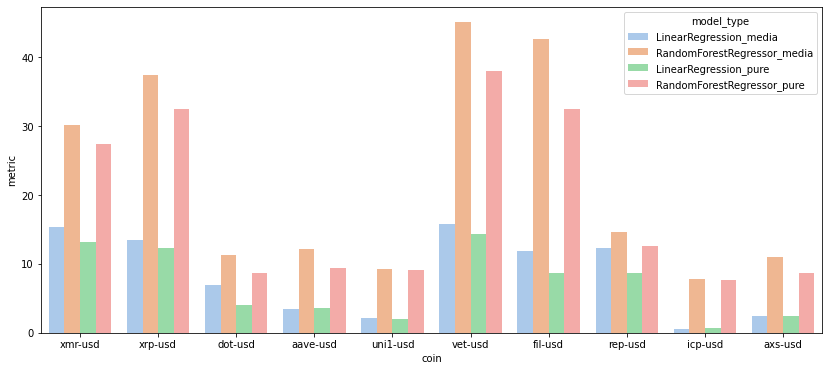

In [51]:
fig, ax = plt.subplots(figsize=(14, 6))
coins_low = ["xmr-usd", "xrp-usd", "dot-usd", "aave-usd", "uni1-usd", "vet-usd", "fil-usd", "rep-usd", "icp-usd", "axs-usd"]
coins_high = [x for x in res.coin.unique() if x != "btc-usd" and x not in coins_low]
coins_btc = ["btc-usd"]
sns.barplot(data=res[res.coin.isin(coins_low)], x="coin", y="metric", hue="model_type", ax=ax, palette="pastel")
plt.show(ax)

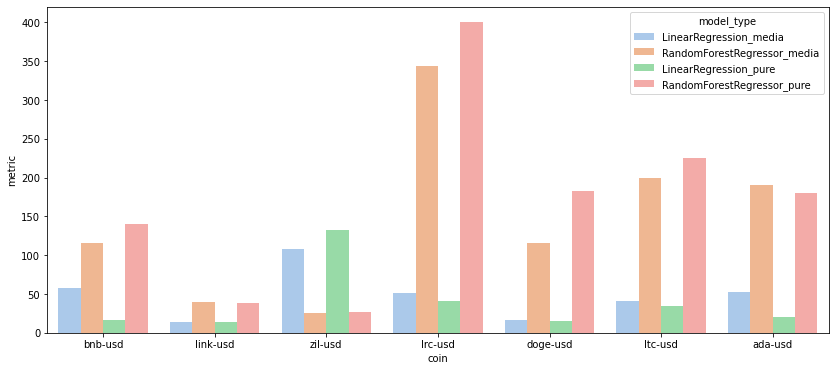

In [53]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(data=res[res.coin.isin(coins_high)], x="coin", y="metric", hue="model_type", ax=ax, palette="pastel")
plt.show(ax)

In [60]:
res[res.coin == "btc-usd"]

,model,coin,metric,type,model_type
4,LinearRegression,btc-usd,70.721581,media,LinearRegression_media
5,RandomForestRegressor,btc-usd,3669.071687,media,RandomForestRegressor_media
4,LinearRegression,btc-usd,69.574715,pure,LinearRegression_pure
5,RandomForestRegressor,btc-usd,3606.136179,pure,RandomForestRegressor_pure


In [87]:
res0.model = res0.model.astype(str).str.encode('utf-8')
res0.coin = res0.coin.astype(str).str.encode('utf-8')
res0["model_coin"] = res0.model + res0.coin
res1.model = res1.model.astype(str).str.encode('utf-8')
res1.coin = res1.coin.astype(str).str.encode('utf-8')
res1["model_coin"] = res1.model + res1.coin

In [100]:
res0 = res0.sort_values("model_coin")
res1 = res1.sort_values("model_coin")
temp = pd.concat((res0, res1.rename(columns={"metric": "metric_pure"})), axis=1)

In [105]:
temp[temp["metric"] < temp["metric_pure"]][["model", "coin"]]

,model,model,coin,coin
12,b'LinearRegression',b'LinearRegression',b'aave-usd',b'aave-usd'
28,b'LinearRegression',b'LinearRegression',b'icp-usd',b'icp-usd'
20,b'LinearRegression',b'LinearRegression',b'zil-usd',b'zil-usd'
1,b'RandomForestRegressor',b'RandomForestRegressor',b'bnb-usd',b'bnb-usd'
25,b'RandomForestRegressor',b'RandomForestRegressor',b'doge-usd',b'doge-usd'
23,b'RandomForestRegressor',b'RandomForestRegressor',b'lrc-usd',b'lrc-usd'
31,b'RandomForestRegressor',b'RandomForestRegressor',b'ltc-usd',b'ltc-usd'
21,b'RandomForestRegressor',b'RandomForestRegressor',b'zil-usd',b'zil-usd'


In [102]:
(temp["metric"] < temp["metric_pure"]).mean()

0.2222222222222222

In [106]:
media_better = temp[temp.metric < temp.metric_pure]
((media_better.metric_pure - media_better.metric) / media_better.metric_pure).mean()

0.1506717349034812